In [1]:
import os
import requests
from dotenv import load_dotenv

load_dotenv()
SILICONFLOW_API_KEY = os.getenv("SILICONFLOW_API_KEY")

In [2]:
import re

def clean_text(text):
	"""
	清理文本内容，去除Wiki标记和多余格式。
	"""
	text = re.sub(r'\{\{对话\|([^|]+)\|([^}]+)\}\}', lambda m: f"{m.group(1)}：{m.group(2).replace('<br>', ' ')}", text)

	text = re.sub(r'\{\{(?:xh|xl|状态|物品|任务|货币|版本|地图)\|([^|}]*)[^}]*\}\}', r'\1', text)

	text = re.sub(r'\{\{Role\|[^|]+\|([^}]+)\}\}', r'\1', text)

	text = re.sub(r'\{\{[^}]+text=([^|}]+)[^}]*\}\}', r'\1', text)

	text = re.sub(r'\{\{黑幕\|([^}]+)\}\}', r'\1', text)
	text = re.sub(r'<span[^>]*class="blackcover"[^>]*>(.*?)</span>', r'\1', text)

	text = re.sub(r'\[\[(?:[^|\]]+\:)?([^|\]]+\|)?([^\]]+)\]\]', lambda m: m.group(2) if m.group(2) else m.group(1).split('|')[0], text)

	text = re.sub(r'<[^>]+>', '', text)
	text = re.sub(r"'''", '', text) 
	text = re.sub(r"''", '', text)

	text = re.sub(r'\{\{[^}]+\}\}', '', text)

	text = re.sub(r'={2,}([^=]+)={2,}', r'\1', text)
	text = re.sub(r'^\*+', '· ', text, flags=re.MULTILINE)

	lines = [line.strip() for line in text.splitlines() if line.strip()]
	return "\n".join(lines)

def process_docs(input_dir, output_dir):
	"""
	处理输入目录中的所有文本文件，清理内容后保存到输出目录。
	"""
	if not os.path.exists(output_dir):
		os.makedirs(output_dir)

	for filename in os.listdir(input_dir):
		if filename.endswith(".txt"):
			with open(os.path.join(input_dir, filename), 'r', encoding='utf-8') as f:
				content = f.read()
			
			clean_content = clean_text(content)
			
			with open(os.path.join(output_dir, filename), 'w', encoding='utf-8') as f:
				f.write(clean_content)
			print(f"成功清洗: {filename}")

In [3]:
RAW_DIR = "./docs_raw"
CLEAN_DIR = "./docs_clean"

if os.path.exists(RAW_DIR):
	process_docs(RAW_DIR, CLEAN_DIR)
	print("--- 清洗完成 ---")
else:
	print(f"错误: 找不到源文件夹 {RAW_DIR}")

成功清洗: doc1.txt
成功清洗: doc2.txt
--- 清洗完成 ---


In [4]:
# 准备向量化与 RAG 调用
import requests
import json
import numpy as np


In [5]:
# BGE-M3 向量化函数
def get_embedding(text):
	"""调用 BGE-M3 获取文本向量"""
	url = "https://api.siliconflow.cn/v1/embeddings"
	headers = {
		"Authorization": f"Bearer {SILICONFLOW_API_KEY}",
		"Content-Type": "application/json"
	}
	payload = {
		"model": "BAAI/bge-m3",
		"input": [text]
	}
	resp = requests.post(url, headers=headers, json=payload)
	data = resp.json()
	return data["data"][0]["embedding"]

# 测试
sample_text = "Agentic RAG 是结合检索与生成的系统"
vector = get_embedding(sample_text)
print(f"向量长度: {len(vector)}")


向量长度: 1024


In [6]:
def chunk_text(text, min_len=100, max_len=1500):
	"""
	按换行符切分文本，每块长度控制在 min_len ~ max_len 之间。
	- min_len: 避免太短的段落
	- max_len: 避免超过模型 token 限制
	"""
	lines = [line.strip() for line in text.split("\n") if line.strip()]
	chunks = []
	current_chunk = ""
	
	for line in lines:
		if len(current_chunk) + len(line) + 1 <= max_len:
			current_chunk += line + "\n"
		else:
			if len(current_chunk) >= min_len:
				chunks.append(current_chunk.strip())
			current_chunk = line + "\n"
	
	if current_chunk.strip():
		chunks.append(current_chunk.strip())
	
	return chunks


In [7]:
from chromadb import Client, PersistentClient
from chromadb.config import Settings
import os

DB_DIR = "./chroma_db"
COLLECTION_NAME = "text_chunks"

client = PersistentClient(path=DB_DIR)

# 判断是否已有可用向量库
db_exists = os.path.exists(DB_DIR)
collection_names = [c.name for c in client.list_collections()]

if db_exists and COLLECTION_NAME in collection_names:
    collection = client.get_collection(name=COLLECTION_NAME)
    if collection.count() > 0:
        print(f"检测到本地 ChromaDB，已包含 {collection.count()} 个向量，跳过构建")
    else:
        print("集合存在但为空，开始构建向量库")
else:
    print("未检测到本地向量库，开始构建")

# 只有在需要时才构建
if not (db_exists and COLLECTION_NAME in collection_names and collection.count() > 0):
    if COLLECTION_NAME in collection_names:
        collection = client.get_collection(name=COLLECTION_NAME)
    else:
        collection = client.create_collection(name=COLLECTION_NAME)

    for fname in os.listdir(CLEAN_DIR):
        if not fname.endswith(".txt"):
            continue

        with open(os.path.join(CLEAN_DIR, fname), "r", encoding="utf-8") as f:
            text = f.read()

        for i, chunk in enumerate(chunk_text(text)):
            vec = get_embedding(chunk)
            if vec is not None:
                collection.add(
                    ids=[f"{fname}_part{i+1}"],
                    documents=[chunk],
                    embeddings=[vec]
                )

    
    print(f"ChromaDB 向量库构建完成，共 {collection.count()} 个文档块")


检测到本地 ChromaDB，已包含 27 个向量，跳过构建


In [8]:
import requests
import numpy as np

# 检索 + BGE-Reranker 重排
def retrieve(query, top_k=5):
    query_vec = get_embedding(query)
    
    # ChromaDB 初步检索 top_k
    results = collection.query(
        query_embeddings=[query_vec],
        n_results=top_k
    )
    
    # 构建 top_docs
    top_docs = []
    if results['documents']:
        for doc_id, text in zip(results['ids'][0], results['documents'][0]):
            top_docs.append({
                "id": doc_id,
                "text": text
            })
    
    # 调用 BGE-Reranker 进一步重排
    url = "https://api.siliconflow.cn/v1/rerank"
    headers = {
        "Authorization": f"Bearer {SILICONFLOW_API_KEY}",
        "Content-Type": "application/json"
    }
    payload = {
        "model": "BAAI/bge-reranker-v2-m3",
        "query": query,
        "documents": [doc["text"] for doc in top_docs]
    }
    resp = requests.post(url, headers=headers, json=payload)
    data = resp.json()
    
    if "results" in data and data["results"]:
        # 按相关性降序排序
        sorted_indices = [
            item["index"] for item in sorted(
                data["results"],
                key=lambda x: x["relevance_score"],
                reverse=True
            )
        ]
        reranked_docs = [top_docs[i] for i in sorted_indices]
    else:
        reranked_docs = top_docs

    return reranked_docs

# 测试
top_docs = retrieve("什么是 Agentic RAG？")
for i, doc in enumerate(top_docs):
    print(f"Top-{i+1} 文档: {doc['id']}")


Top-1 文档: doc1.txt_part13
Top-2 文档: doc1.txt_part18
Top-3 文档: doc1.txt_part15
Top-4 文档: doc1.txt_part16
Top-5 文档: doc1.txt_part14


In [9]:
# 调用 DeepSeek-R1 生成答案（可选 RAG）
def generate_answer(query, context_docs=None):
    url = "https://api.siliconflow.cn/v1/chat/completions"
    headers = {
        "Authorization": f"Bearer {SILICONFLOW_API_KEY}",
        "Content-Type": "application/json"
    }

    if context_docs:  # 有参考文档，使用 RAG
        context_text = "\n".join([doc["text"] for doc in context_docs])
        prompt = f"""
请根据以下参考内容回答问题，只输出最终答案，不要输出任何思考过程或分析步骤。
严格按照条列格式输出，禁止任何解释或推理。

【参考内容】
{context_text}

【问题】
{query}

【要求】
- 输出必须为 Markdown 条列形式，并且尽可能简洁
- 不允许出现任何“我认为 / 首先 / 我需要思考 / 接下来 / 为了确认”等语言
"""
    else:  # 没有参考文档，直接回答问题
        prompt = f"""
请回答以下问题，只输出最终答案，不要输出任何思考过程或分析步骤。
严格按照条列格式输出，禁止任何解释或推理。

【问题】
{query}

【要求】
- 输出必须为 Markdown 条列形式，并且尽可能简洁
- 不允许出现任何“我认为 / 首先 / 我需要思考 / 接下来 / 为了确认”等语言
"""

    payload = {
        "model": "deepseek-ai/DeepSeek-R1-Distill-Qwen-7B",
        "messages": [
            {
                "role": "system",
                "content": "你是一个只输出最终答案的模型。输出必须完全遵守 Markdown 条列格式，禁止输出任何过程性思考、推理或解释段落。"
            },
            {
                "role": "user",
                "content": prompt
            }
        ],
        "max_tokens": 2000,
        "temperature": 0
    }

    resp = requests.post(url, headers=headers, json=payload)
    content = resp.json()["choices"][0]["message"]["content"]

    if "</think>" in content:
        answer = content.split("</think>")[-1].strip()
    else:
        answer = content.strip()

    return answer


In [10]:

# 测试
answer_with_docs = generate_answer("什么是 Agentic RAG？", top_docs)
print("生成答案（RAG）:\n", answer_with_docs)

print("-" * 50)

answer_without_docs = generate_answer("什么是 Agentic RAG？")
print("生成答案（无 RAG）:\n", answer_without_docs)


生成答案（RAG）:
 Agentic RAG 暂无明确定义，可能指游戏中主动控制或使用的某种角色或装备组合。
--------------------------------------------------
生成答案（无 RAG）:
 **Agentic RAG** 是一种基于代理人的检索增强生成模型，用于对话系统中，通过结合检索和生成能力，提升对话理解和生成效率。


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import evaluate

# 初始化指标
rouge = evaluate.load("rouge")
bertscore = evaluate.load("bertscore")

def evaluate_answer(pred_answer, reference_answer, visualize=True):
    """
    使用 ROUGE 评估模型答案
    如果 visualize=True，会直接画图
    """
    results = rouge.compute(predictions=[pred_answer], references=[reference_answer])

    if visualize:
        # 提取主要指标
        metrics = ['rouge1', 'rouge2', 'rougeL']
        scores = [results[m] for m in metrics]

        plt.figure(figsize=(6,4))
        sns.barplot(x=metrics, y=scores, hue=metrics, palette="Blues_d")
        plt.ylim(0,1)
        plt.title("ROUGE Scores")
        plt.ylabel("Score")
        plt.show()

    return results


def evaluate_answer_bert(pred_answer, reference_answer, visualize=True, lang="zh"):
    """
    使用 BERTScore 评估语义相似度
    如果 visualize=True，会直接画图
    """
    results = bertscore.compute(predictions=[pred_answer], references=[reference_answer], lang=lang)

    if visualize:
        metrics = ['precision', 'recall', 'f1']
        scores = [results[m][0] for m in metrics]  # bertscore 返回列表
        plt.figure(figsize=(6,4))
        sns.barplot(x=metrics, y=scores, hue=metrics, palette="Greens_d")
        plt.ylim(0,1)
        plt.title("BERTScore Scores")
        plt.ylabel("Score")
        plt.show()

    return results


In [12]:
def call_llm(prompt: str, model="deepseek-ai/DeepSeek-R1-Distill-Qwen-7B", max_tokens=2000, temperature=0):
    """
    通用 LLM 调用模板，返回文本结果。
    自动截断 </think> 内容，保证只取最终输出。
    """
    url = "https://api.siliconflow.cn/v1/chat/completions"
    headers = {
        "Authorization": f"Bearer {SILICONFLOW_API_KEY}",
        "Content-Type": "application/json"
    }

    payload = {
        "model": model,
        "messages": [
            {"role": "system", "content": "你是一个智能助手，只根据提示返回结果"},
            {"role": "user", "content": prompt}
        ],
        "max_tokens": max_tokens,
        "temperature": temperature
    }

    try:
        resp = requests.post(url, headers=headers, json=payload)
        data = resp.json()
        content = data["choices"][0]["message"]["content"].strip()
        # 截断 </think> 及其之前的内容，只保留最终输出
        if "</think>" in content:
            content = content.split("</think>")[-1].strip()
        return content
    except Exception as e:
        print("LLM 调用失败:", e)
        return ""


In [13]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict

# 定义状态结构
class State(TypedDict, total=False):
    query: str
    context_docs: list
    need_rag: bool
    answer: str
    answer_correct: bool
    step: int
    max_steps: int

# 创建图
graph_builder = StateGraph(State)

# 实时打印状态
def log_hook(node_name, state):
    step = state.get("step", 0)
    need_rag = state.get("need_rag", None)
    answer = state.get("answer", None)
    answer_correct = state.get("answer_correct", None)
    context_docs = state.get("context_docs", [])

    print(f"\n[Node] {node_name}")
    print(f"Step: {step}")
    if need_rag is not None:
        print(f"Need RAG: {need_rag}")
    if context_docs:
        print(f"Docs ({len(context_docs)}): {[doc['text'][:50] for doc in context_docs]}")
    if answer is not None:
        print(f"Answer: {answer}")
    if answer_correct is not None:
        print(f"Answer correct: {answer_correct}")

# 记录当前的论数
def step_node(state: State):
    step = state.get("step", 0) + 1
    print(f"\n========== Round {step} ==========")
    return {"step": step}

# 判断是否需要 RAG
def need_rag_node(state: State):
    """
    使用大模型判断是否需要 RAG：
    - 将 query 和 top_docs 一起输入 LLM
    - LLM 输出 YES 或 NO
    - YES → 需要 RAG
    - NO  → 不需要 RAG，直接大模型回答
    """
    query = state.get("query", "")
    top_docs = retrieve(query)

    # 保存 top_docs 到状态里，以便 RAG 节点使用
    state["context_docs"] = top_docs

    # 如果没有文档，直接大模型回答
    if not top_docs:
        return {"need_rag": False}

    # 构造提示词
    docs_text = "\n\n".join([doc["text"] for doc in top_docs])
    prompt = f"""
你是一个智能助手。
请判断以下问题是否需要参考提供的文档来回答。
严格要求：
- 只输出 YES 或 NO，必须大写
- 不允许任何解释或其他内容

问题: {query}
参考文档:
{docs_text}
"""

    decision = call_llm(prompt)
    need_rag = "YES" in decision.upper()
    return {"need_rag": need_rag}

# RAG 节点
def rag_node(state: State):
    query = state.get("query", "")
    docs = state.get("context_docs", [])

    print(f"[RAG] Using {len(docs)} docs")
    for i, doc in enumerate(docs, 1):
        preview = doc["text"][:200].replace("\n", " ")
        print(f"  Doc-{i}: {preview} ...")

    answer = generate_answer(query, context_docs=docs)
    print(f"[Answer - RAG]\n{answer}\n")

    return {"answer": answer}

# 直接回答节点
def direct_answer_node(state: State):
    query = state.get("query", "")
    answer = generate_answer(query)

    print("[Answer - Direct]")
    print(answer, "\n")

    return {"answer": answer}

# 判断是否满足需求
def check_correct_node(state: State):
    correct = check_answer_correct(
        query=state.get("query"),
        answer=state.get("answer"),
        context_docs=state.get("context_docs"),
        need_rag=state.get("need_rag")
    )

    print(f"[Check] Answer correct: {correct}")

    return {"answer_correct": correct}

def correct_routing(state: State):
    if state.get("answer_correct", False):
        return "end"

    if state.get("step", 0) >= state.get("max_steps", 3):
        return "end"

    return "retry"


In [14]:
graph_builder.add_node("step", step_node)
graph_builder.add_node("need_rag", need_rag_node)
graph_builder.add_node("rag", rag_node)
graph_builder.add_node("direct_answer", direct_answer_node)
graph_builder.add_node("check_correct", check_correct_node)

graph_builder.add_edge(START, "step")
graph_builder.add_edge("step", "need_rag")

graph_builder.add_conditional_edges(
    "need_rag",
    lambda s: "rag" if s.get("need_rag") else "direct_answer"
)

graph_builder.add_edge("rag", "check_correct")
graph_builder.add_edge("direct_answer", "check_correct")

graph_builder.add_conditional_edges(
    "check_correct",
    correct_routing,
    {
        "end": END,
        "retry": "step"
    }
)

graph = graph_builder.compile()

In [15]:
def check_answer_correct(query, answer, need_rag, context_docs=None):
    """
    使用 LLM 判断答案是否正确：
    - 如果有 context_docs（RAG 文档），将 query + docs + answer 输入 LLM
    - 如果没有 context_docs，直接用 query + answer 判断
    """
    if need_rag and context_docs and len(context_docs) > 0:
        docs_text = "\n\n".join([doc["text"] for doc in context_docs])
        prompt = f"""
你是一个严格的评判模型。
请判断以下回答是否正确回答了问题。
严格要求：
- 只输出 YES 或 NO，必须大写
- 不允许任何解释或条列
- 不允许输出其他内容

问题: {query}
参考文档:
{docs_text}

回答: {answer}
"""
    else:
        prompt = f"""
你是一个严格的评判模型。
请判断以下回答是否正确回答了问题。
严格要求：
- 只输出 YES 或 NO，必须大写
- 不允许任何解释或条列
- 不允许输出其他内容

问题: {query}
回答: {answer}
"""
    judgement = call_llm(prompt)
    return "YES" in judgement.upper()


In [16]:
def run_query_with_react(query: str, max_iters: int = 3):
    """
    每轮循环打印 ReAct 当前决策：
    - 是否需要 RAG
    - 当前回答节点
    - 当前答案
    """
    top_docs = retrieve(query)
    state = {
        "query": query,
        "context_docs": top_docs,
        "step": 0,
        "max_steps": max_iters
    }
    output = graph.invoke(state, post_node_hook=log_hook)
    return output.get("answer", "")



========== Round 1 ==========
[Answer - Direct]
**Agentic RAG** 是一种结合检索和生成的主动式方法，用于增强生成任务的性能。 

[Check] Answer correct: True
最终答案:
 **Agentic RAG** 是一种结合检索和生成的主动式方法，用于增强生成任务的性能。


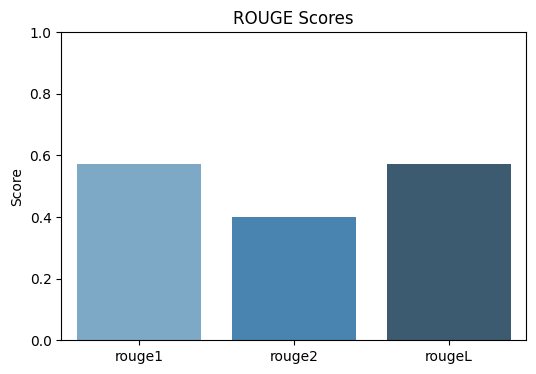

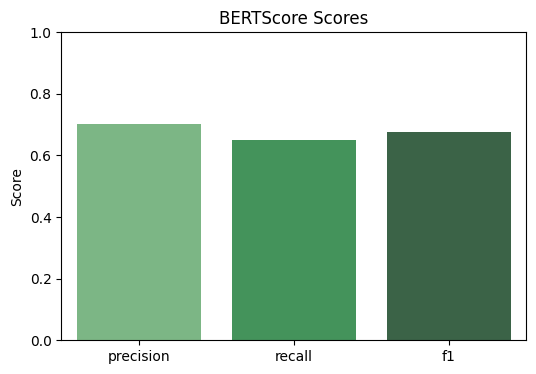

ROUGE 测评结果: {'rouge1': np.float64(0.5714285714285715), 'rouge2': np.float64(0.4), 'rougeL': np.float64(0.5714285714285715), 'rougeLsum': np.float64(0.5714285714285715)}
BERTScore 测评结果: {'precision': [0.7021312713623047], 'recall': [0.6518111228942871], 'f1': [0.6760361194610596], 'hashcode': 'bert-base-chinese_L8_no-idf_version=0.3.12(hug_trans=4.57.6)'}


In [17]:
final_answer = run_query_with_react("什么是 Agentic RAG？")
print("最终答案:\n", final_answer)

reference = """
Agentic RAG 是一种引入了智能代理（AI Agent）能力的 RAG 架构，它不仅能检索信息，还能通过自我思考、多步推理、工具调用及结果评估，自主优化查询路径以提供更精准的答案。
"""

pred_answer = final_answer
rouge_scores = evaluate_answer(pred_answer, reference)
bert_scores = evaluate_answer_bert(pred_answer, reference)

print("ROUGE 测评结果:", rouge_scores)
print("BERTScore 测评结果:", bert_scores)


========== Round 1 ==========
[Answer - Direct]
- 型号：G17  
- 部件数量：6张  
- 底座功率：30w  
- 版本：v10 

[Check] Answer correct: True
最终答案:
 - 型号：G17  
- 部件数量：6张  
- 底座功率：30w  
- 版本：v10


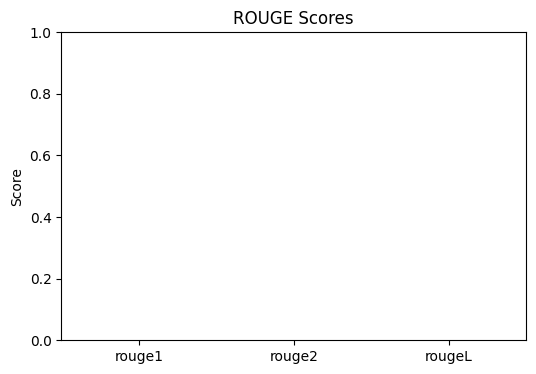

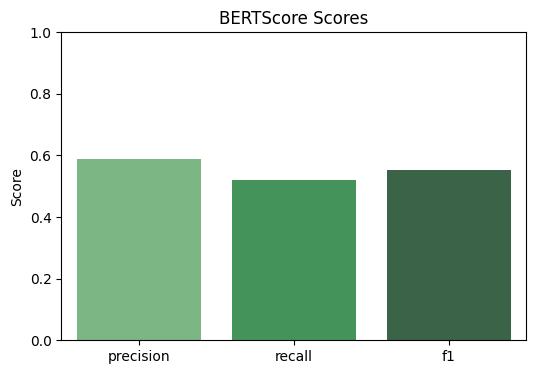

ROUGE 测评结果: {'rouge1': np.float64(0.0), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.0), 'rougeLsum': np.float64(0.0)}
BERTScore 测评结果: {'precision': [0.587311863899231], 'recall': [0.5209823250770569], 'f1': [0.552162230014801], 'hashcode': 'bert-base-chinese_L8_no-idf_version=0.3.12(hug_trans=4.57.6)'}


In [18]:
final_answer = run_query_with_react("‘G17 6张 底30w 挂件v10’是什么意思？")
print("最终答案:\n", final_answer)

reference = """
寻宝陈旧的狞豹革地图，一共挖六张，打工仔底薪为30万游戏币，如果进宝物库成功突破最终区域（俗称见底/下底）的情况下给贡献藏宝图的队长10万金币。
"""

pred_answer = final_answer
rouge_scores = evaluate_answer(pred_answer, reference)
bert_scores = evaluate_answer_bert(pred_answer, reference)

print("ROUGE 测评结果:", rouge_scores)
print("BERTScore 测评结果:", bert_scores)



========== Round 1 ==========
[RAG] Using 5 docs
  Doc-1: ·  P_：指Boss的第_个阶段，如P1、P2等。通常使用副本中的标志性技能（如：月读幽夜歼灭战“黄泉之舞”）/Boss上天无敌（如：须佐之男歼灭战）/Boss变形（如：萨菲洛特歼灭战）/场地变更（如：神龙歼灭战）/召唤小怪（如：索菲娅歼灭战）作为分P标志。 ·  正攻：指全员正面处理机制，不使用非常规手段强行承受伤害。 ·  逃课：指通过某些特定机制（如LB）等非常规方式强行承受错误处理机制时 ...
  Doc-2: · 饭：指士气高涨，决斗获胜的玩家可获得丰厚奖励，同时决斗场地附近的玩家也会获得状态士气高涨士气高涨60分钟（增加100%的战果获取量） 蜃景幻界新月岛 · 荔枝塔：两歧塔 力之塔 · 劳改：一般指攻略力之塔失败后，掉级刷CE的过程 · FATE：会在副本内各处触发的无参加人数限制的战斗事件。前往地图上标注的触发地点即可参加。 · CE：指紧急遭遇战（Critical Engagement），没有 ...
  Doc-3: P1 · 攻击：月读的普通攻击为对一仇目标的物理伤害。 · 责难：全屏AOE。 · 深宵换装：读条结束后月读随机拔出火枪或长枪，预备无读条的释放黄泉之弹或黄泉之枪，并伴有对应的台词提示： · 火枪：尽情哭喊吧！ · 长枪：还能坚持多久呢？ · 在P1，深宵换装固定释放两次且两次必定不相同。 · 使用火枪时有子弹上膛音效，使用长枪时有金属摩擦音效。 · 黄泉之弹：点名随机1名玩家释放可分摊的直线AO ...
  Doc-4: · 深宵换装：第二次极月读的深宵换装必定为长枪。 · 黄泉之舞：无读条带有明显特效的全屏AOE，为自身赋予死刀流，进入P4。 P4 · 攻击：月读的普通攻击为对一仇目标的物理伤害。 · 月刀左斩/月刀右斩：范围不可见的对应方向+前方210度扇形Aoe，每次发动必定发动两次且方向相反。每次发动前会无读条的为自身赋予满月流或新月流，带有满月和新月的显著特效与提示： · 满月：满月的魔力充盈着月读……  ...
  Doc-5: · 鬼观梦：在红玉海刷新的危命任务做梦的大名——大名观梦螺，因为与地图A级狩猎怪鬼观梦过于相似，因此常被误认为鬼观梦 特殊fate相关 · 奥丁：在黑衣森林各林区刷新的危

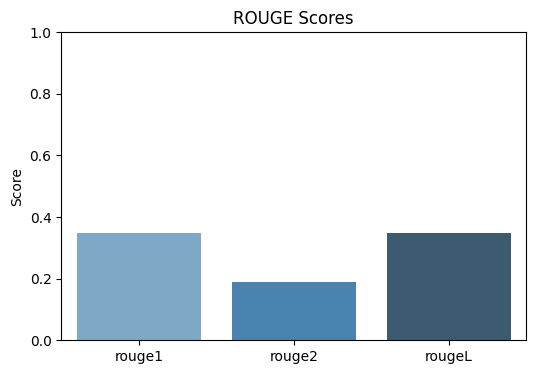

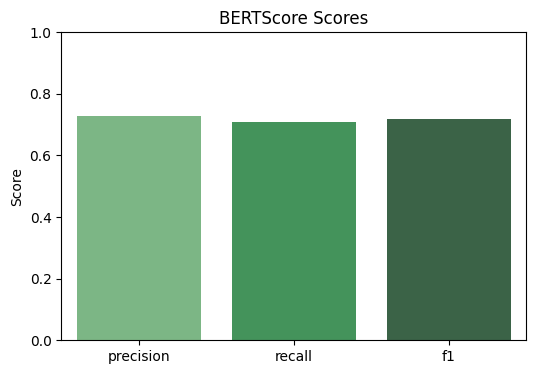

ROUGE 测评结果: {'rouge1': np.float64(0.34782608695652173), 'rouge2': np.float64(0.1904761904761905), 'rougeL': np.float64(0.34782608695652173), 'rougeLsum': np.float64(0.34782608695652173)}
BERTScore 测评结果: {'precision': [0.7281872630119324], 'recall': [0.7072264552116394], 'f1': [0.7175538539886475], 'hashcode': 'bert-base-chinese_L8_no-idf_version=0.3.12(hug_trans=4.57.6)'}


In [19]:
final_answer = run_query_with_react("月读极神的核心机制是什么？")
print("最终答案:\n", final_answer)

reference = """
- 极月读：赋予数名玩家四层的新月下，其余玩家四层的满月下，场地被分割为黑（新月）白（满月）两色的区域，10秒后其中一色会扩散形成月牙形结构。在黑色地板上5秒会获得一层新月下，在白色地板上5秒后会获得一层满月下，并消除异色buff。叠加到五层新月下满月下会被附加15秒的出血和1秒的死亡宣告，在死亡宣告判定前移动到异色地面可以消除死亡宣告。
- 满月流/新月流：月刀左斩/月刀右斩每次发动前会同步发动的圆形/环形AOE。
- 月下缭乱：点名随机1名玩家连续释放初始为4次可分摊的圆形AOE，每释放一次，就会为下一次月下缭乱增加一段伤害，在狂暴前共有三次。
- 破月：点名随机各1名防护治疗和进攻职能玩家释放先后顺序随机的分三次释放不可回避的圆形AOE。
"""

pred_answer = final_answer
rouge_scores = evaluate_answer(pred_answer, reference)
bert_scores = evaluate_answer_bert(pred_answer, reference)

print("ROUGE 测评结果:", rouge_scores)
print("BERTScore 测评结果:", bert_scores)